# Currency rates forecasting

The idea is to divide all samples to portions and predict every 7 future currency rates basing on 28 past days.<br>
All data was downloaded from [Bank of Russia](http://cbr.ru/eng/currency_base/dynamics/ "Bank of Russia") website.

The solution is based on cross-validation using <i>LOO (leave-out-out)</i>, i.e. test set coontains 28 samples for $X$ and 7 samples for $y$. To find optimal parameters __GridSearch__ is applied to several <i>regression algorithms</i> of scikit-learn. At the end of the notebook results are given in final table.

In [19]:
# !pip install xlrd

In [226]:
import pandas as pd

df = pd.read_excel("data/usd_rates.xlsx", parse_dates=['data'], columns=['data', 'curs'])
df = df.rename(columns={'data': 'date'})
df.describe()

,nominal,curs
count,744.0,744.000000
mean,1.0,62.160322
std,0.0,4.012836
min,1.0,55.671700
25%,1.0,58.327125
50%,1.0,62.454100
75%,1.0,65.648475
max,1.0,75.899400


In [228]:
df.curs.quantile(0.95)

68.21926

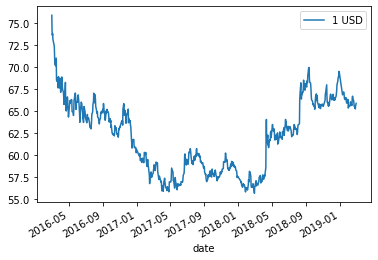

In [229]:
df.plot(x='date', y='curs', label='1 USD')

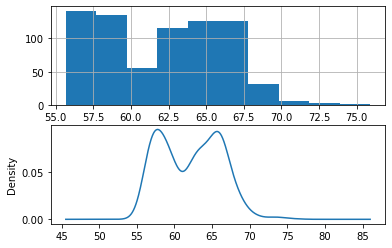

In [154]:
import matplotlib.pyplot as plt

# looking at histogram of currency rates and density helps to understand anomaly values in time series and distribution
# density plot demonstrates that rates have bimodal distribution during the period

plt.figure(1)
plt.subplot(211)
df.curs.hist()
plt.subplot(212)
df.curs.plot(kind='kde')
plt.show()

In [155]:
past = 4*7
future = 7

In [156]:
start = past
end = len(df.curs) - future
money = df.curs.values
money = money.reshape(-1, 1)

In [157]:
new_df = []
for i in range(start, end):
    all_days = money[(i - past):(i+future)]
    new_df.append(list(all_days))

In [158]:
past_columns = []
for i in range(past):
    past_columns.append(f"past_{i}")

In [159]:
future_columns = []
for i in range(future):
    future_columns.append(f"future_{i}")

In [160]:
transformed_df = pd.DataFrame(new_df, columns=(past_columns + future_columns))
transformed_df.head()

,past_0,past_1,past_2,past_3,past_4,past_5,past_6,past_7,past_8,past_9,...,past_25,past_26,past_27,future_0,future_1,future_2,future_3,future_4,future_5,future_6
0,[75.8994],[74.0536],[73.6256],[73.8242],[73.1854],[72.3775],[71.0928],[70.3067],[70.1542],[70.5408],...,[68.5215],[67.796],[67.4662],[67.125],[66.3456],[65.7662],[66.4954],[66.0452],[68.2724],[65.6474]
1,[74.0536],[73.6256],[73.8242],[73.1854],[72.3775],[71.0928],[70.3067],[70.1542],[70.5408],[71.0256],...,[67.796],[67.4662],[67.125],[66.3456],[65.7662],[66.4954],[66.0452],[68.2724],[65.6474],[66.0364]
2,[73.6256],[73.8242],[73.1854],[72.3775],[71.0928],[70.3067],[70.1542],[70.5408],[71.0256],[68.5598],...,[67.4662],[67.125],[66.3456],[65.7662],[66.4954],[66.0452],[68.2724],[65.6474],[66.0364],[65.0254]
3,[73.8242],[73.1854],[72.3775],[71.0928],[70.3067],[70.1542],[70.5408],[71.0256],[68.5598],[68.4026],...,[67.125],[66.3456],[65.7662],[66.4954],[66.0452],[68.2724],[65.6474],[66.0364],[65.0254],[66.2198]
4,[73.1854],[72.3775],[71.0928],[70.3067],[70.1542],[70.5408],[71.0256],[68.5598],[68.4026],[68.8086],...,[66.3456],[65.7662],[66.4954],[66.0452],[68.2724],[65.6474],[66.0364],[65.0254],[66.2198],[66.6295]


In [161]:
test_len = 1
train_X = transformed_df[past_columns][:-test_len]
train_y = transformed_df[future_columns][:-test_len]

In [162]:
test_X = transformed_df[past_columns][-test_len:]
test_y = transformed_df[future_columns][-test_len:]

In [163]:
# tryung to normalize data
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler

min_max_scaler = MinMaxScaler()
max_abs_scaler = MaxAbsScaler()
standard_scaler = StandardScaler()

scaled_train_X = standard_scaler.fit_transform(train_X) # max_abs_scaler.fit_transform(train_X) # min_max_scaler.fit_transform(train_X) 
scaled_test_X = standard_scaler.fit_transform(test_X)  # max_abs_scaler.fit_transform(test_X) # min_max_scaler.fit_transform(test_X) 

In [164]:
# normalized values do the LinearModel worse in our case
from sklearn.linear_model import LinearRegression

model = LinearRegression(n_jobs=-1, normalize=True) 
model.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [165]:
prediction = model.predict(test_X)
prediction

array([[66.17991412, 66.12349371, 66.09432247, 66.00256775, 65.91867656,
        65.9778731 , 66.00915148]])

In [166]:
test_y

,future_0,future_1,future_2,future_3,future_4,future_5,future_6
708,[66.2022],[65.8568],[65.5401],[65.5149],[65.2582],[65.6182],[65.757]


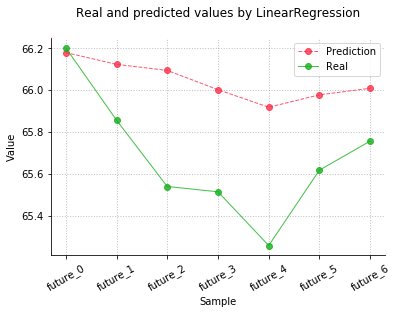

In [167]:
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().set_xlabel('Sample')
plt.gca().set_ylabel('Value')
plt.xticks(rotation=30)
plt.grid(b=True, color='gray', alpha=0.5, linestyle='dotted', linewidth=1)

plt.plot(prediction[0], label="Prediction", color='xkcd:lightish red', ls='--', 
         alpha=0.8, marker='o', linewidth=1)
plt.plot(test_y.iloc[0], label="Real", color='xkcd:green', 
         alpha=0.8, marker='o', linewidth=1)
plt.title('Real and predicted values by LinearRegression\n')
plt.legend()

plt.show()

In [168]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

print('mae: ', round(mae(prediction[0], test_y.iloc[0]), 3))
print('R2:',  round(r2_score(test_y.iloc[0], prediction[0]), 3))

mae:  0.372
R2: -1.314


**GridSearchCV helps to find best parameters for each algorithm**

In [169]:
from sklearn.neighbors import KNeighborsRegressor

import numpy as np
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()
k_range = [2, 3, 4, 5, 6, 8]

# описание сетки
param_grid = {
    'n_neighbors' : k_range,
    'weights' : ['uniform', 'distance'],
    'metric': ['manahattan', 'euclidean', 'minkowski'],
    'p': [1,2,3]
}

In [ ]:
search = GridSearchCV(knn, param_grid, n_jobs=-1)
search.fit(train_X, train_y)
print("R2: {}".format(search.best_score_))
search.best_params_

In [ ]:
search_grid_df = pd.DataFrame(data=search.cv_results_)
search_grid_df.describe()

In [36]:
KNN = KNeighborsRegressor(n_neighbors=8, algorithm='auto', 
                          metric='minkowski', weights='uniform', p=1, 
                          n_jobs=-1)
KNN.fit(train_X, train_y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
                    weights='uniform')

In [37]:
prediction = KNN.predict(test_X)

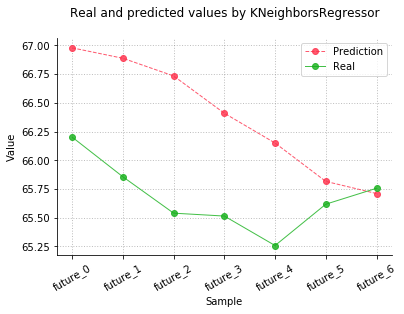

In [38]:
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().set_xlabel('Sample')
plt.gca().set_ylabel('Value')
plt.xticks(rotation=30)
plt.grid(b=True, color='gray', alpha=0.5, linestyle='dotted', linewidth=1)

plt.plot(prediction[0], label="Prediction", color='xkcd:lightish red', ls='--', 
         alpha=0.8, marker='o', linewidth=1)
plt.plot(test_y.iloc[0], label="Real", color='xkcd:green', 
         alpha=0.8, marker='o', linewidth=1)
plt.title('Real and predicted values by KNeighborsRegressor\n')
plt.legend()

plt.show()

In [39]:
print('mae: ', round(mae(prediction[0], test_y.iloc[0]), 3))
print('R2:',  round(r2_score(test_y.iloc[0], prediction[0]), 3))

mae:  0.719
R2: -7.795


$R^2$ is negative and large, so despite ``mae=0.719`` ``KNeighborsRegressor`` is an <i>inappropriate</i> model to predict currency rates. KNN shown the results even worse than ``LinearRegression``. Data normalization is also not suitable here.

## MLPRegressor

Searching for **hyperparameters** for MLPRegressor (i.e. multilayer perceptrone). 
According to the [link](https://stats.stackexchange.com/a/136542):<br>
<center>$N_{h}=\frac{N_s}{\alpha({N_i+N_o})}$,</center>
<br>
$N_i$ - number of input neurons<br>
$N_o$ - number of output neurons<br>
$N_s$ - number of samples in training data set<br>
$\alpha$ - an arbitrary scaling factor usually 2-10 (the most common $\alpha$ is 2).

In [41]:
# MLPRegressor can be also tuned with GridSearchCV
from sklearn.neural_network import MLPRegressor

In [ ]:
MLP = MLPRegressor()

# parameter for k-fold cross validation in GridSearchCV
k_fold = 5

param_grid = {
    'activation' : ['relu', 'tanh', 'logistic'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha' : [0.001, 0.0005, 0.0001],
    'max_iter': [1000, 2000, 5000],
    'hidden_layer_sizes': [(70), (10,), (26,), (10,10)]
}
search = GridSearchCV(MLP, param_grid, cv=k_fold, n_jobs=-1)
search.fit(train_X, train_y)
print("R2: {}".format(search.best_score_))
search.best_params_

In [ ]:
search_grid_df = pd.DataFrame(data=search.cv_results_)
search_grid_df.describe()

In [42]:
MLP = MLPRegressor(random_state=42, activation='relu', alpha=0.001, 
                   solver='lbfgs', max_iter=5000, hidden_layer_sizes=(26,))
MLP.fit(train_X, train_y)

MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(26,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=5000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [43]:
prediction = MLP.predict(test_X)

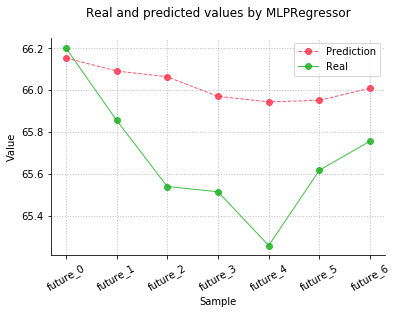

In [44]:
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().set_xlabel('Sample')
plt.gca().set_ylabel('Value')
plt.xticks(rotation=30)
plt.grid(b=True, color='gray', alpha=0.5, linestyle='dotted', linewidth=1)

plt.plot(prediction[0], label="Prediction", color='xkcd:lightish red', ls='--',
         alpha=0.8, marker='o', linewidth=1)
plt.plot(test_y.iloc[0], label="Real",  color='xkcd:green', 
         alpha=0.8, marker='o', linewidth=1)
plt.title('Real and predicted values by MLPRegressor\n')
plt.legend()
plt.show()

In [45]:
print('mae: ', round(mae(prediction[0], test_y.iloc[0]), 3))
print('R2:',  round(r2_score(test_y.iloc[0], prediction[0]), 3))

mae:  0.362
R2: -1.202


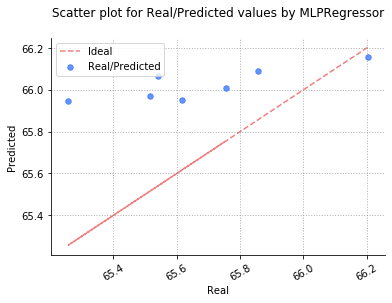

In [46]:
# scatter plot of real and predicted values
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().set_xlabel('Real')
plt.gca().set_ylabel('Predicted')
plt.xticks(rotation=30)
plt.grid(b=True, color='gray', alpha=0.6, linestyle='dotted', linewidth=1)

plt.scatter(test_y.iloc[0], prediction, label='Real/Predicted',
            color='xkcd:lightish blue', alpha=0.8, s=30, zorder=2)
plt.plot(test_y.iloc[0], test_y.iloc[0], label='Ideal',
         color='xkcd:red', alpha=0.5, ls='--', zorder=1)
plt.title('Scatter plot for Real/Predicted values by MLPRegressor\n')

plt.legend()

plt.show()

The scatter plot shows the quality of predictions, i.e. how close are predicted values to real ones.

# Trying to predict with ensemble and tree algorithms

### 1. Ensemble method of scikit-klearn - RandomForestRegressor. Searching for parameters with GridSearchCV. 

Optimal parameter recommendations were described [here](https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/)

In [71]:
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [100, 200, 300, 500]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None]

# Maximum number of levels in tree
max_depth = [10, 20, 40, 60, 100]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 30]

# Minimum number of samples required at each leaf node
min_samples_leaf = [50, 60, 80]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap,
              'oob_score': [True, False]}

trees_num = 1
for val in param_grid.values():
    trees_num *=  len(val)
print("A number of regressors for GridSearchCV: ", trees_num)

A number of regressors for GridSearchCV:  3456


In [72]:
RF = RandomForestRegressor()

# parameter for k-fold cross validation in GridSearchCV
k_fold = 5

search = GridSearchCV(RF, param_grid, cv=k_fold, n_jobs=-1)
search.fit(train_X, train_y)
search.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': None,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'n_estimators': 500,
 'oob_score': False}

In [ ]:
search_grid_df = pd.DataFrame(data=search.cv_results_)
search_grid_df.describe()

In [99]:
print("R2: {}".format(search.best_score_))
model = RandomForestRegressor(random_state=42, n_estimators=500, 
                              max_features=None, bootstrap=False,
                              min_samples_split=2, max_depth=20, 
                              min_samples_leaf=10, oob_score=False,
                              n_jobs=-1)
model.fit(train_X, train_y)

R2::0.1628151752083574


RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=None, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [92]:
prediction = model.predict(test_X)

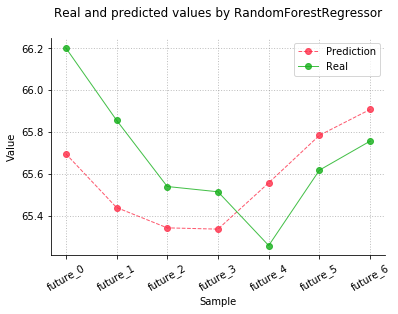

In [93]:
# scatter plot of real and predicted values
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().set_xlabel('Sample')
plt.gca().set_ylabel('Value')
plt.xticks(rotation=30)
plt.grid(b=True, color='gray', alpha=0.5, linestyle='dotted', linewidth=1)

plt.plot(prediction[0], label="Prediction", color='xkcd:lightish red', ls='--', 
         alpha=0.8, marker='o', linewidth=1)
plt.plot(test_y.iloc[0], label="Real", color='xkcd:green', 
         alpha=0.8, marker='o', linewidth=1)
plt.title('Real and predicted values by RandomForestRegressor\n')
plt.legend()

plt.show()

In [94]:
print('mae: ', round(mae(prediction[0], test_y.iloc[0]), 3))
print('R2:',  round(r2_score(test_y.iloc[0], prediction[0]), 3))

mae:  0.274
R2: -0.19


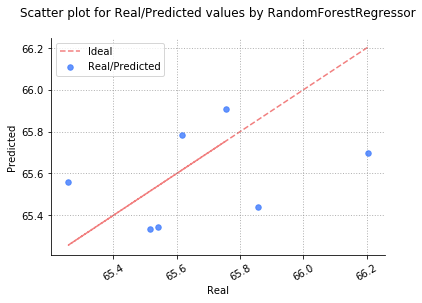

In [95]:
# scatter plort for true and predicted values
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().set_xlabel('Real')
plt.gca().set_ylabel('Predicted')
plt.xticks(rotation=30)
plt.grid(b=True, color='gray', alpha=0.6, linestyle='dotted', linewidth=1)

plt.scatter(test_y.iloc[0], prediction, label='Real/Predicted',
            color='xkcd:lightish blue', alpha=0.8, s=30, zorder=2)
plt.plot(test_y.iloc[0], test_y.iloc[0], label='Ideal',
         color='xkcd:red', alpha=0.5, ls='--', zorder=1)
plt.title('Scatter plot for Real/Predicted values by RandomForestRegressor\n')

plt.legend()

plt.show()

## 2. DecisionTreeRegressor approach

### Hyperparameter tuning with GridSearchCV

In [120]:
from sklearn.tree import DecisionTreeRegressor

# Create the random grid
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [2, 8, 20, 40],
              "max_depth": [2, 6, 8, 20, 40],
              "min_samples_leaf": [20, 30, 40, 60, 100],
              "max_leaf_nodes": [5, 20, 50, 100],
              }

trees_num = 1
for val in param_grid.values():
    trees_num *=  len(val)
print("A number of regressors for GridSearchCV: ", trees_num)

A number of regressors for GridSearchCV:  800


In [121]:
DTREE = DecisionTreeRegressor()

# parameter for k-fold cross validation in GridSearchCV
k_fold = 5

search = GridSearchCV(DTREE, param_grid, cv=k_fold, n_jobs=-1)
search.fit(train_X, train_y)
print("R2: {}".format(search.best_score_))
search.best_params_

R2: 0.29401860715301503


{'criterion': 'mse',
 'max_depth': 8,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 20,
 'min_samples_split': 2}

In [132]:
search_grid_df = pd.DataFrame(data=search.cv_results_)
search_grid_df.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
count,800.000000,800.000000,800.000000,8.000000e+02,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.326234,0.016459,0.005614,6.364795e-04,-0.281795,0.755216,-0.948295,0.688927,-1.265262,-0.210242,0.933776,389.618750
std,0.329997,0.019865,0.000727,5.435230e-04,0.316665,0.036039,1.227375,0.069657,0.528233,0.331662,0.277324,225.154345
min,0.015457,0.000001,0.004496,3.504023e-07,-0.602471,0.695146,-2.883962,0.611185,-1.878041,-0.764595,0.546976,1.000000
25%,0.018931,0.000495,0.004995,3.896474e-04,-0.519775,0.737195,-2.405922,0.611185,-1.796109,-0.419928,0.678060,200.750000
50%,0.200176,0.005644,0.005385,5.392949e-04,-0.480411,0.749460,-0.523557,0.638932,-1.119401,-0.197866,0.945082,400.500000
75%,0.608444,0.029022,0.006105,8.759543e-04,0.074921,0.777738,0.095817,0.752459,-0.883469,0.019142,1.230051,600.250000
max,0.999584,0.127368,0.013190,6.995060e-03,0.278326,0.819401,0.381622,0.796973,-0.497450,0.294019,1.404438,753.000000


In [233]:
DTREE = DecisionTreeRegressor(random_state=42, criterion='mse', max_depth=8,
                              min_samples_leaf=20, max_leaf_nodes=100, min_samples_split=2)
DTREE.fit(train_X, train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=100,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [234]:
prediction = DTREE.predict(test_X)

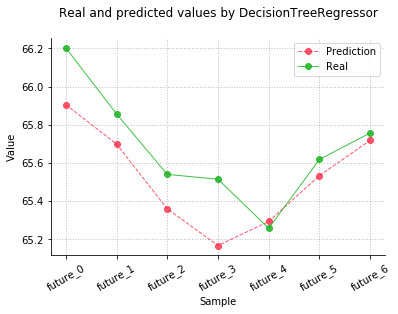

In [235]:
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().set_xlabel('Sample')
plt.gca().set_ylabel('Value')
plt.xticks(rotation=30)
plt.grid(b=True, color='gray', alpha=0.5, linestyle='dotted', linewidth=1)

plt.plot(prediction[0], label="Prediction", color='xkcd:lightish red', ls='--', 
         alpha=0.8, marker='o', linewidth=1)
plt.plot(test_y.iloc[0], label="Real", color='xkcd:green', 
         alpha=0.8, marker='o', linewidth=1)
plt.title('Real and predicted values by DecisionTreeRegressor\n')
plt.legend()

plt.show()

In [136]:
print('mae: ', round(mae(prediction[0], test_y.iloc[0]), 3))
print('R2:',  round(r2_score(test_y.iloc[0], prediction[0]), 3))

mae:  0.163
R2: 0.487


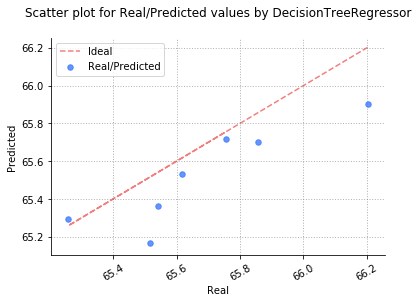

In [137]:
# scatter plort for true and predicted values
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().set_xlabel('Real')
plt.gca().set_ylabel('Predicted')
plt.xticks(rotation=30)
plt.grid(b=True, color='gray', alpha=0.6, linestyle='dotted', linewidth=1)

plt.scatter(test_y.iloc[0], prediction, label='Real/Predicted',
            color='xkcd:lightish blue', alpha=0.8, s=30, zorder=2)
plt.plot(test_y.iloc[0], test_y.iloc[0], label='Ideal',
         color='xkcd:red', alpha=0.5, ls='--', zorder=1)
plt.title('Scatter plot for Real/Predicted values by DecisionTreeRegressor\n')

plt.legend()

plt.show()

The current parameters of ``DecisionTreeRegressor``, i.e. ``criterion='mse', max_depth=8, min_samples_leaf=20, max_leaf_nodes=100, min_samples_split=2`` show better $R^2$ and ``mse`` by comparison to ``RandomForestRegressor``.

## 3. One more sklearn ensemble method - BaggingRegressor

In [193]:
from sklearn.ensemble import BaggingRegressor

# Create the random grid
param_grid = {"bootstrap": [True, False],
              "bootstrap_features": [True, False],
              "max_samples": [0.3, 0.5, 1.0],
              "max_features": np.arange(0.1, 1.0, 0.3),
              "n_estimators": np.arange(10, 300, 10),
              "oob_score": [True, False],
              "warm_start": [True, False]
              }

trees_num = 1
for val in param_grid.values():
    trees_num *=  len(val)
print("A number of regressors for GridSearchCV: ", trees_num)

A number of regressors for GridSearchCV:  4176


In [194]:
BR = BaggingRegressor()

# parameter for k-fold cross validation in GridSearchCV
k_fold = 5

search = GridSearchCV(BR, param_grid, cv=k_fold, n_jobs=-1)
search.fit(train_X, train_y)
print("R2: {}".format(search.best_score_))
search.best_params_

R2: 0.2470577540880325


{'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 0.7000000000000001,
 'max_samples': 0.3,
 'n_estimators': 40,
 'oob_score': False,
 'warm_start': True}

In [195]:
search_grid_df = pd.DataFrame(data=search.cv_results_)
search_grid_df.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
count,4176.000000,4.176000e+03,4176.000000,4.176000e+03,2088.000000,2088.000000,2088.000000,2088.000000,2088.000000,2088.000000,2088.000000,4176.000000
mean,1.395746,7.592798e-02,0.028524,5.371755e-03,-0.086949,0.799373,-0.312450,0.730515,-1.023854,0.021327,0.692475,2088.500000
std,1.686930,1.053406e-01,0.044476,4.430560e-02,0.239732,0.042704,0.142683,0.036418,0.263993,0.098583,0.075200,1205.651691
min,0.003391,1.784161e-07,0.000000,0.000000e+00,-1.036403,0.593691,-1.565226,0.487577,-2.191791,-0.365527,0.561274,1.000000
25%,0.009279,1.595756e-03,0.000000,0.000000e+00,-0.270020,0.754960,-0.362803,0.719750,-1.319929,-0.059764,0.633255,1044.750000
50%,0.622037,3.407594e-02,0.001496,1.846782e-07,-0.116856,0.821869,-0.277727,0.734134,-0.906117,0.031632,0.664115,2088.500000
75%,2.477789,1.113271e-01,0.052110,7.132022e-03,0.111147,0.833667,-0.221396,0.751548,-0.820076,0.107116,0.768921,3132.250000
max,10.107293,1.475577e+00,1.424703,2.823474e+00,0.376981,0.866193,0.152569,0.814732,-0.494481,0.247058,1.070275,4176.000000


In [219]:
model = BaggingRegressor(random_state=42, bootstrap=True, bootstrap_features=False,
                         max_features=0.7, max_samples=0.3, n_estimators=40,
                         oob_score=False, warm_start=True,
                         n_jobs=-1, )
model.fit(train_X, train_y)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=0.7, max_samples=0.3, n_estimators=40, n_jobs=-1,
                 oob_score=False, random_state=42, verbose=0, warm_start=True)

In [220]:
prediction = model.predict(test_X)

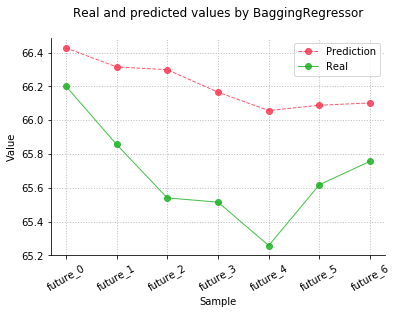

In [221]:
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().set_xlabel('Sample')
plt.gca().set_ylabel('Value')
plt.xticks(rotation=30)
plt.grid(b=True, color='gray', alpha=0.5, linestyle='dotted', linewidth=1)

plt.plot(prediction[0], label="Prediction", color='xkcd:lightish red', ls='--', 
         alpha=0.8, marker='o', linewidth=1)
plt.plot(test_y.iloc[0], label="Real", color='xkcd:green', 
         alpha=0.8, marker='o', linewidth=1)
plt.title('Real and predicted values by BaggingRegressor\n')
plt.legend()

plt.show()

In [222]:
print('mae: ', round(mae(prediction[0], test_y.iloc[0]), 3))
print('R2:',  round(r2_score(test_y.iloc[0], prediction[0]), 3))

mae:  0.53
R2: -3.159


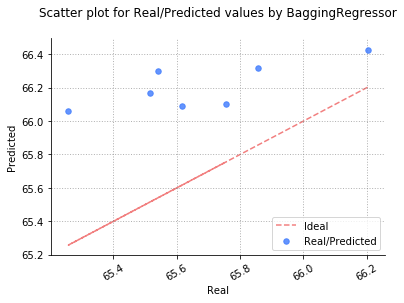

In [224]:
# scatter plot of real and predicted values
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().set_xlabel('Real')
plt.gca().set_ylabel('Predicted')
plt.xticks(rotation=30)
plt.grid(b=True, color='gray', alpha=0.6, linestyle='dotted', linewidth=1)

plt.scatter(test_y.iloc[0], prediction, label='Real/Predicted',
            color='xkcd:lightish blue', alpha=0.8, s=30, zorder=2)
plt.plot(test_y.iloc[0], test_y.iloc[0], label='Ideal',
         color='xkcd:red', alpha=0.5, ls='--', zorder=1)
plt.title('Scatter plot for Real/Predicted values by BaggingRegressor\n')

plt.legend()

plt.show()

Different configurations of ``BaggingRegressor`` (overall number of ``4176``) give worse results than ``DecisionTreeRegressor`` and even ``RandomForestRegressor``. 

``mae`` of the optimal configuration of ``BaggingRegressor`` is ``0.53`` and $R^2=-3.159$ which is not only relatively large, but also negative. Probably, more properly parameters search with ``GridSearchCV`` can give much better results.<br>
Thus, the ensemble method ``BaggingRegressor`` in current configuration is not suitable for current predictions.

# Conclusion 
K-Fold cross-validation (K=5) used in models above gives the results below. The table is sorted by $R^2$ column:

|Model|mae|$R^2$|
|-----|-------|-------|
|``DecisionTreeRegressor``|``0.163``|``0.487``|
|``RandomForestRegressor``|``0.274``|``-0.19``|
|``MLPRegressor``|``0.362``|``-1.202``|
|``LinearRegression``|``0.372``|``-1.314``|
|``BaggingRegressor``|``0.53``|``-3.159``|
|``KNeighborsRegressor``|``0.719``|``-7.795``|